# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [1]:
import os, torch, torchvision, math, random
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["TZ"] = "US/Central"

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Load the CIFAR-10 dataset
- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In [2]:
from convolutional_networks import extract_tensors
# Hyperparameters
validation_ratio=0.2
dtype=torch.float32

# Compound X & Y training and testing tensors 
num_train=None
num_test=None
download = not os.path.isdir("cifar-10-batches-py")
dset_train = CIFAR10(root=".", download=download, train=True)
dset_test = CIFAR10(root=".", train=False)
X_train, y_train = extract_tensors(dset_train, num_train, dtype)
X_test, y_test = extract_tensors(dset_test, num_test, dtype)

**Visualize Class Data**

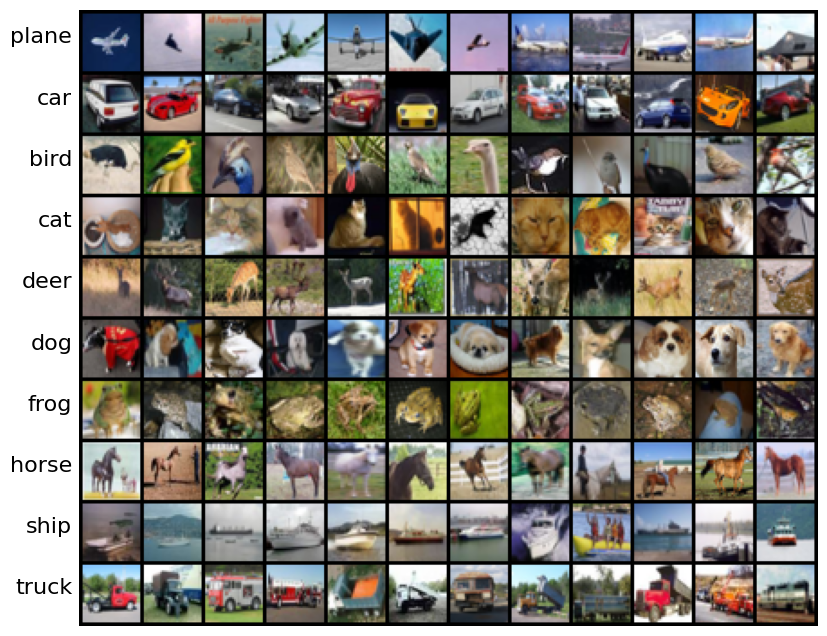

In [3]:
from convolutional_networks import tensor_to_image
# Visualize examples from the dataset.
classes = [ "plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck",]
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha="right")
    (idxs,) = (y_train == y).nonzero(as_tuple=True)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        samples.append(X_train[idx])
img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
plt.imshow(tensor_to_image(img))
plt.axis("off")
plt.show()

## Process Data 

In [4]:
# Normalize the data: subtract the mean RGB (zero mean)
mean_image = X_train.mean(dim=(0, 2, 3), keepdim=True)
X_train -= mean_image
X_test -= mean_image

# Take the validation set from the training set
num_training = int(X_train.shape[0] * (1.0 - validation_ratio))
num_validation = X_train.shape[0] - num_training

# Setup data dictionary with dataset
data_dict = {}
data_dict["X_val"] = X_train[num_training:num_training + num_validation]
data_dict["y_val"] = y_train[num_training:num_training + num_validation]
data_dict["X_train"] = X_train[0:num_training]
data_dict["y_train"] = y_train[0:num_training]
data_dict["X_test"] = X_test
data_dict["y_test"] = y_test

### Display Data Tensor Sizes

In [5]:
#  Visualize data shapes
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


# Naive Model

### Create Model Architecture

In [6]:
from convolutional_networks import DeepConvNet

num_train = 500
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=False,
                    reg=1e-5, 
                    fast=True, 
                    dtype=torch.float32, 
                    device='cpu')

### Train Naive Model

In [7]:
from convolutional_networks import Solver, adam, sgd_momentum

solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20,
                device='cpu')
solver.train()

(Time 0.39 sec; Iteration 1 / 50) loss: 2.359287
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.086600
(Epoch 1 / 10) train acc: 0.122000; val_acc: 0.102900
(Epoch 2 / 10) train acc: 0.130000; val_acc: 0.101600
(Epoch 3 / 10) train acc: 0.226000; val_acc: 0.152800
(Epoch 4 / 10) train acc: 0.298000; val_acc: 0.216200
(Time 12.17 sec; Iteration 21 / 50) loss: 2.040602
(Epoch 5 / 10) train acc: 0.320000; val_acc: 0.238100
(Epoch 6 / 10) train acc: 0.354000; val_acc: 0.259300
(Epoch 7 / 10) train acc: 0.414000; val_acc: 0.275000
(Epoch 8 / 10) train acc: 0.416000; val_acc: 0.292900
(Time 20.93 sec; Iteration 41 / 50) loss: 1.667929
(Epoch 9 / 10) train acc: 0.440000; val_acc: 0.291500
(Epoch 10 / 10) train acc: 0.390000; val_acc: 0.264700


### Visualize Naive Loss

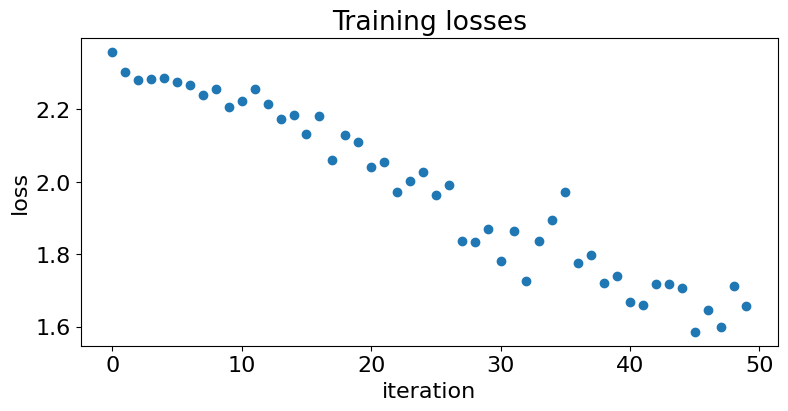

In [8]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

### Visualize Naive Accuracy

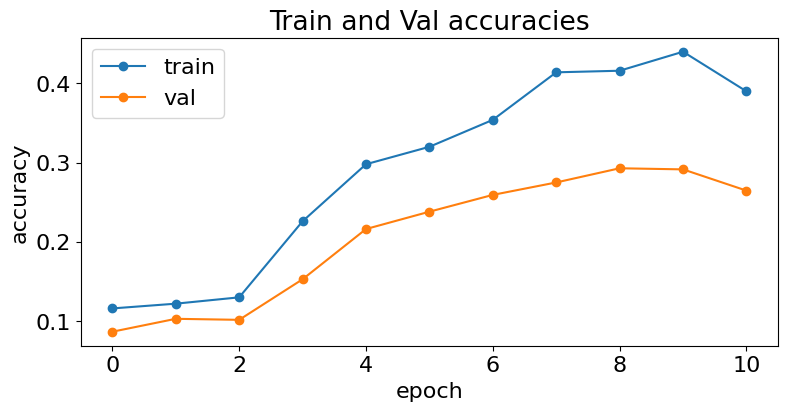

In [9]:
plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

# Deep CNN Model

### Define Model Architecture

In [10]:
from convolutional_networks import DeepConvNet

# Model hyperparameters
num_train = 10000 # Number of images to train
num_classes = 10 # Number of scores to produce 
num_filters = [8, 8, 16, 16, 32, 32] # Number of conv filters to use in each  layer
max_pools = [1, 3, 5] # Desired indices max pooling layers
weight_scale = 'kaiming' # Scalar std for random initialization of weights, or "kaiming" to utilize Kaiming initialization
batchnorm = True # Toggle for layer batch normalization
fast = True # Utilize supplied fast conv and maxpool functions or naive self implementation of conv and maxpool 
regularization = 1e-5 # Scalar for L2 regularization strength

# Grab data to train on based on num_train
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

### Train Model with Different Learning Rates

In [11]:
# Define solver hyperparameters
num_epochs = 15 # Number of epochs to run during training
batch_size = 128 # Size of minibatches used to compute loss and gradient during training
learning_rates = [5e-3, 1e-3, 5e-4] # Scalars that determine learning strength
update_rule = adam # Function for update rule. Reccomended Options: sgd, sgd_momentum, or adam

# Train for each learning rate
solvers = []
for lr in learning_rates:
  print('Training Deep Convolutional Neural Network with learning rate = ', lr)
  # Create Model
  model = DeepConvNet(
    input_dims=input_dims, 
    num_classes=num_classes,
    num_filters=num_filters,
    max_pools=max_pools,
    weight_scale=weight_scale,
    batchnorm=batchnorm,
    reg=regularization, 
    fast=fast,
    dtype=torch.float32, 
    device='cpu'
  )
  # Train Model (note: this will take a long time on local cpu)
  solver = Solver(
    model, 
    small_data,
    num_epochs=num_epochs, 
    batch_size=batch_size,
    update_rule=update_rule,
    optim_config={'learning_rate': lr,},
    verbose=False, 
    device='cpu'
    )
  solver.train()
  solvers.append(solver)

Training Deep Convolutional Neural Network with learning rate =  0.005
Training Deep Convolutional Neural Network with learning rate =  0.001
Training Deep Convolutional Neural Network with learning rate =  0.0005


### Visualize the Comparison of Learning Rate Accuracies

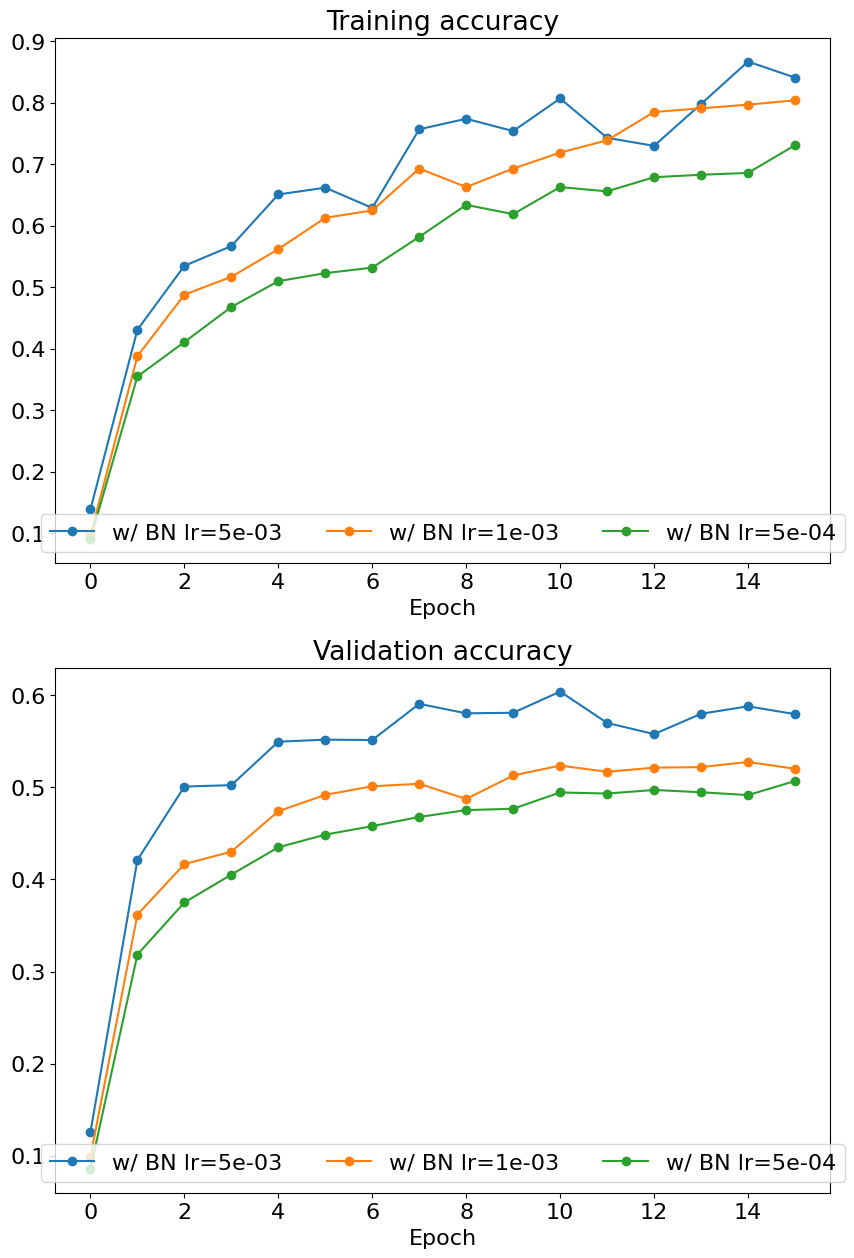

In [12]:
# Utility function for plotting training history
def plot_training_history_bn(title, label, solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
  plt.title(title)
  plt.xlabel(label)
  bn_plots = [plot_fn(solver) for solver in solvers]
  num_bn = len(bn_plots)
  for i in range(num_bn):
    label='w/ BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bn_plots[i], bn_marker, label=label)
  plt.legend(loc='lower center', ncol=num_bn)

# Visualize Training accuracy
plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy','Epoch', solvers, \
  lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in learning_rates])

# Visualize Validation accuracy
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy','Epoch', solvers, \
  lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in learning_rates])

plt.gcf().set_size_inches(10, 15)
plt.show()

### Visualize Loss of Best Learning Rate

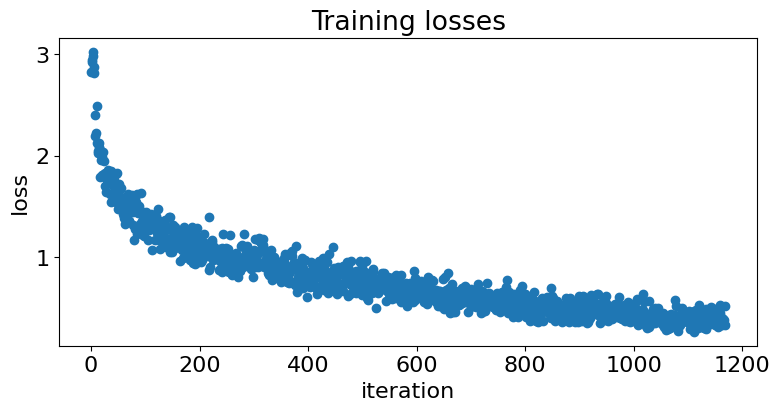

In [13]:
# Find the solver with the best validation accuracy
best_solver = None
best_val_acc = 0.0
for solver in solvers:
    if solver.best_val_acc > best_val_acc:
        best_val_acc = solver.best_val_acc
        best_solver = solver

plt.title('Training losses')
plt.plot(best_solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

### Visualize Accuracy of Best Learning Rate

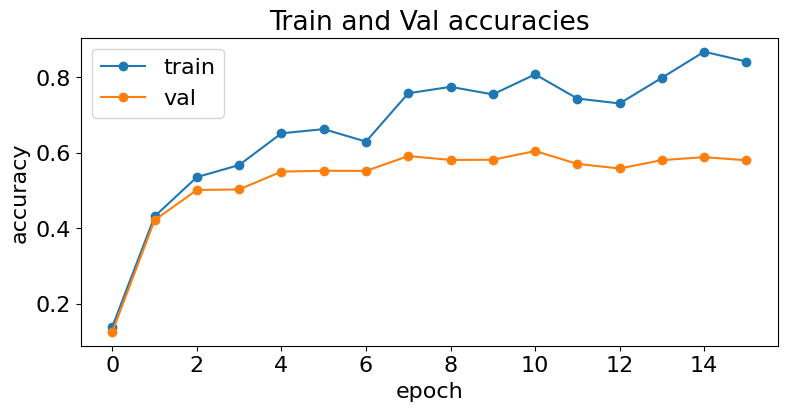

In [14]:
plt.title('Train and Val accuracies')
plt.plot(best_solver.train_acc_history, '-o')
plt.plot(best_solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

### Visualize Filters of Best Learning Rate

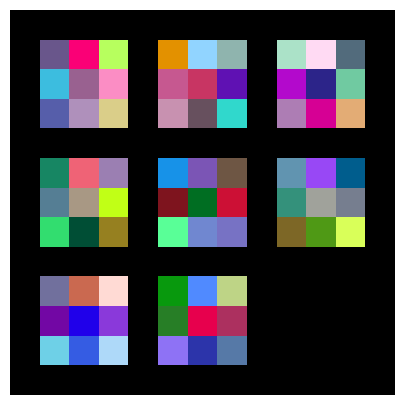

In [15]:
from torchvision.utils import make_grid

nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()